In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import *
from scipy.stats import gamma
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull
from matplotlib.cm import ScalarMappable
from lifelines import WeibullFitter

In [50]:
# RUL bound formulas
def compute_s_bounds(mu, k, t, alpha, Rel=None):
    if Rel is None:
        gt = t
    else:
        exponent = k / (1 - k)
        gt = (mu /  k) * (1 - np.power(Rel(t), exponent))
    exp = k / (1 - k)
    term = (mu / k - gt)
    s_plus = term * (1 - (alpha / 2)**exp)
    s_minus = term * (1 - (1 - alpha / 2)**exp)
    return s_minus, s_plus

# Bootstrap function to estimate uncertainty in bounds
def bootstrap_s_bounds(ttf_data, t, alpha=0.1, alpha_bstp=0.1, B=1000):
    s_plus_samples, s_minus_samples, k_samples = [], [], []
    for b in range(B):
        #if b % 100 == 0 or b == B - 1:
        #     print(f'Bootstrap sample {b+1}/{B}')
        sample = np.random.choice(ttf_data, size=len(ttf_data), replace=True)
        mu_b = np.mean(sample)
        if mu_b == 0:
            print('mu_b=0...continue')
            continue
        cv_b = np.std(sample) / mu_b
        if cv_b >= 1:
            print('k becomes invalid (k becomes negative (1-CV**2)...continue')
            continue  #
        k_b = (1 - cv_b**2) / (1 + cv_b**2)
        k_samples.append(k_b)
        if k_b <= 0 or k_b >= 1:
            print('k is not in [0,1]...continue')
            continue  # avoid unstable k
        #survival_model = WeibullFitter().fit(sample, label='WeibullFitter')
        #Rel = lambda t_eval: survival_model.survival_function_at_times(t_eval).values[0]
        #s_minus, s_plus = compute_s_bounds(mu_b, k_b, t, alpha, Rel)
        s_minus, s_plus = compute_s_bounds(mu_b, k_b, t, alpha)
        s_plus_samples.append(s_plus)
        s_minus_samples.append(s_minus)
    Q_Levels = [(alpha_bstp/2)*100, (1-alpha_bstp/2)*100]
    s_lower_bounds = np.percentile(s_minus_samples, Q_Levels)
    s_upper_bounds = np.percentile(s_plus_samples, Q_Levels)
    k_bounds = np.percentile(k_samples, Q_Levels)
    return (s_lower_bounds, s_upper_bounds, k_bounds)


In [55]:

def sampling_uncertainty_experiment(B=1000,
                                    t_eval = 500,
                                    alpha = 0.1,
                                    alpha_bootstrap  = 0.1 ):
    # Simulate data
    np.random.seed(42)
    true_data = np.random.weibull(a=1.5, size=1000) * 5000  # scaled to make times reasonable
    data_sizes = np.arange(50, 1_500, 50)  # Evaluate for increasing data volumes
    print_lvl = int(100 * (1 - alpha_bootstrap))

    counter = 0
    s_minus_bounds, s_plus_bounds, k_bounds = [], [], []
    for size in data_sizes:  # repeat for data volumes
        counter +=1
        # print(f'{counter}/{len(data_sizes)}')
        ttf_subset = true_data[:size]
        s_m_bounds, s_p_bounds, k_p_bounds = bootstrap_s_bounds(ttf_subset,
                                                                t=t_eval,
                                                                B=B,
                                                                alpha=alpha,
                                                                alpha_bstp=alpha_bootstrap)
        s_minus_bounds.append(s_m_bounds)
        s_plus_bounds.append(s_p_bounds)
        k_bounds.append(k_p_bounds)

    # Convert to arrays for plotting
    s_minus_bounds = np.array(s_minus_bounds)
    s_plus_bounds = np.array(s_plus_bounds)
    k_bounds = np.array(k_bounds)

    # Create 3 subpanels
    fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharex=True)

    # Font settings
    title_font, label_font= {'fontsize': 16}, {'fontsize': 16}
    tick_fontsize, legend_fontsize = 14, 14
    loc = 'lower right'
    # Panel 1: k bounds
    axs[0].plot(data_sizes, k_bounds[:, 0], 'b--o', label=f'k lower, {(100 * ( alpha_bootstrap / 2)):.1f}%', markersize=6)
    axs[0].plot(data_sizes, k_bounds[:, 1], 'b-.s', label=f'k upper, {(100 * (1 - alpha_bootstrap / 2)):.1f}%', markersize=6)
    axs[0].set_xlabel("Data Volume", **label_font)
    axs[0].set_ylabel("Bootstrap CI", **label_font)
    axs[0].tick_params(axis='both', labelsize=tick_fontsize)
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].legend(fontsize=legend_fontsize, loc=loc)

    # Panel 2: s+ bounds
    axs[1].plot(data_sizes, s_plus_bounds[:, 0], 'g--o',
                label=f'$s^+$ lower, {100 * (alpha_bootstrap / 2):.1f}%', markersize=6)
    axs[1].plot(data_sizes, s_plus_bounds[:, 1], 'g-.s',
                label=f'$s^+$ upper, {100 * (1 - alpha_bootstrap / 2):.1f}%', markersize=6)
    #axs[1].set_title("Bootstrap CI for $s^+$ (Upper Bound)", **title_font)
    axs[1].set_xlabel("Data Volume", **label_font)
    axs[1].tick_params(axis='both', labelsize=tick_fontsize)
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].legend(fontsize=legend_fontsize, loc=loc)

    # Panel 3: s− bounds
    axs[2].plot(data_sizes, s_minus_bounds[:, 0], 'r--o',
                label=f'$s^-$ lower, {100 * (alpha_bootstrap / 2):.1f}%', markersize=6)
    axs[2].plot(data_sizes, s_minus_bounds[:, 1], 'r-.s',
                label=f'$s^-$ upper, {100 * (1 - alpha_bootstrap / 2):.1f}%', markersize=6)
    #axs[2].set_title("Bootstrap CI for $s^-$ (Lower Bound)", **title_font)
    axs[2].set_xlabel("Data Volume", **label_font)
    axs[2].tick_params(axis='both', labelsize=tick_fontsize)
    axs[2].grid(True, linestyle='--', alpha=0.6)
    axs[2].legend(fontsize=legend_fontsize,loc='lower right')

    plt.suptitle(f"Bootstrap {print_lvl}% Confidence Intervals vs. Data Volume (t={t_eval}, α={alpha})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.savefig("../plots/convergence_example_k_splus_sminus.svg", format="svg")  # ✅ Save SVG
    plt.show()

    # Visualize relative uncertainty decay
    k_lower, k_upper = k_bounds[:, 0], k_bounds[:, 1]
    s_plus_upper, s_plus_lower = s_plus_bounds[:, 0], s_plus_bounds[:, 1]
    s_minus_upper, s_minus_lower = s_minus_bounds[:, 0], s_minus_bounds[:, 1]

    # Compute CI widths (uncertainty)
    k_ci_width = k_upper - k_lower
    s_plus_ci_width = s_plus_upper - s_plus_lower
    s_minus_ci_width = s_minus_upper - s_minus_lower

    # Normalize to first value (relative width of the epistemic uncertainty)
    k_rel_uncert = k_ci_width / k_ci_width[0]
    s_plus_rel_uncert = s_plus_ci_width / s_plus_ci_width[0]
    s_minus_rel_uncert = s_minus_ci_width / s_minus_ci_width[0]

    # Plot relative uncertainty decay
    plt.figure(figsize=(10, 6))
    plt.plot(data_sizes, k_rel_uncert, 'b-o', label='$k$', markersize=6)
    plt.plot(data_sizes, s_plus_rel_uncert, 'g-s', label='$s^+$', markersize=6)
    plt.plot(data_sizes, s_minus_rel_uncert, 'r-^', label='$s^-$', markersize=6)

    plt.xlabel("Data Volume (Sample Size)", **label_font)
    plt.ylabel("Relative Uncertainty \n (Normalized CI Width)", **label_font)
    plt.title("Decay of Relative Uncertainty with Increasing Data Volume", fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=legend_fontsize)
    plt.tick_params(axis='both', labelsize=tick_fontsize)
    plt.tight_layout()
    plt.savefig("../plots/convergence_example_normalized.svg", format="svg")  # ✅ Save SVG
    plt.show()



1/29
2/29
3/29
4/29
5/29
6/29
7/29
8/29
9/29
10/29
11/29
12/29
13/29
14/29
15/29
16/29
17/29
18/29
19/29
20/29
21/29
22/29
23/29
24/29
25/29
26/29
27/29
28/29
29/29


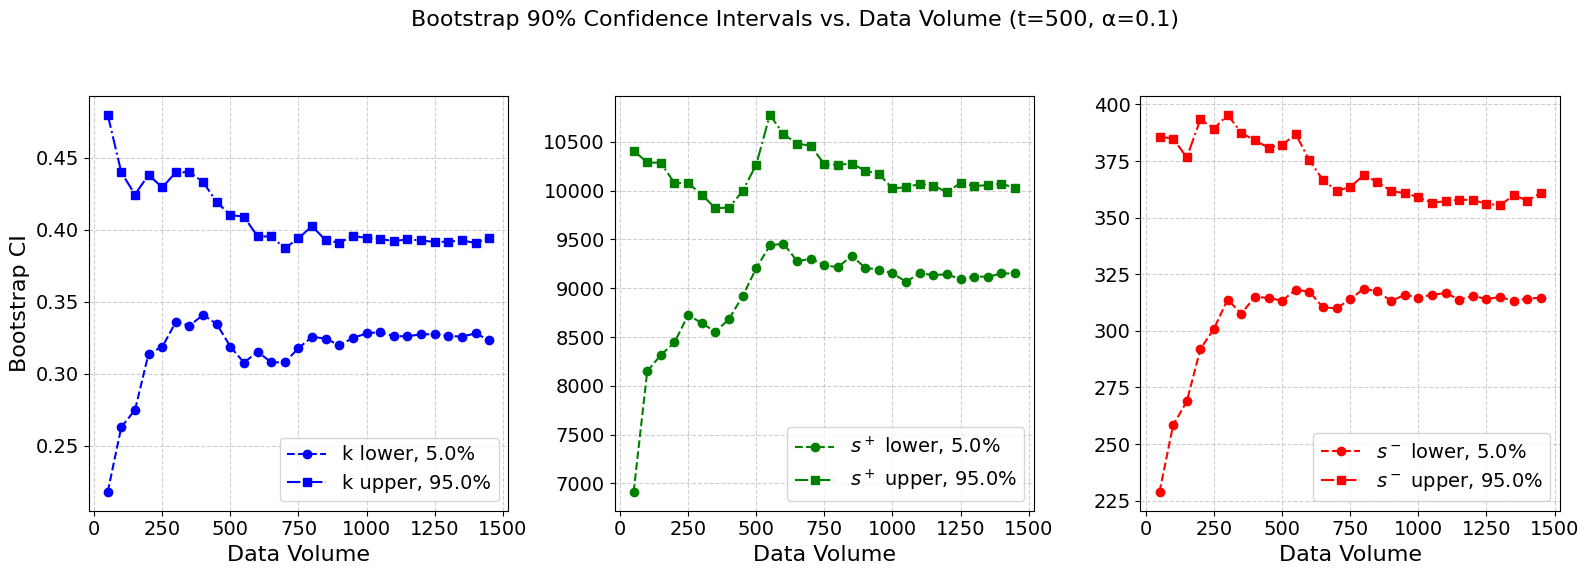

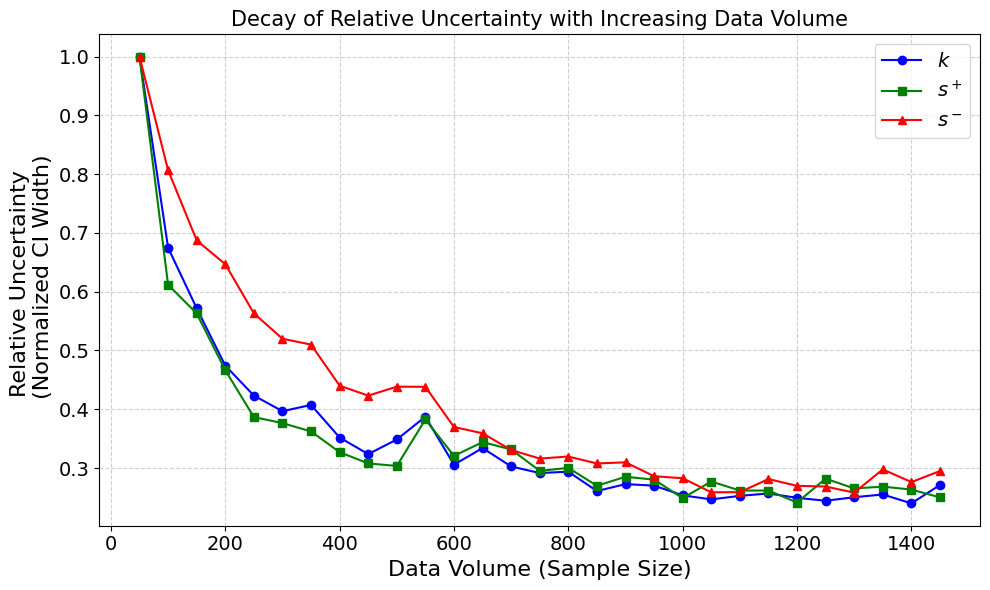

In [56]:
sampling_uncertainty_experiment(B=500) # for

In [3]:

def sampling_uncertainty_experiment_v2(B=100):

    np.random.seed(42)
    true_data = np.random.weibull(a=1.5, size=1000) * 5000  # scaled to make times reasonable

    # Evaluate for increasing data volumes
    data_sizes = np.arange(100, 5_000, 100)
    t_eval = 500
    alpha_levels = [0.05, 0.1, 0.2]  # Multiple alpha levels

    fig, axs = plt.subplots(len(alpha_levels), 3, figsize=(14, 4 * len(alpha_levels)), sharex=True)

    for i, alpha in enumerate(alpha_levels):
        alpha_bootstrap = alpha
        print_lvl = int(100 * (1 - alpha_bootstrap))

        s_minus_bounds = []
        s_plus_bounds = []
        k_bounds = []
        for size in data_sizes:
            ttf_subset = true_data[:size]
            s_m_bounds, s_p_bounds, k_p_bounds = bootstrap_s_bounds(ttf_subset, t=t_eval, B=B,
                                                                    alpha=0.1, alpha_bstp=alpha_bootstrap)
            s_minus_bounds.append(s_m_bounds)
            s_plus_bounds.append(s_p_bounds)
            k_bounds.append(k_p_bounds)

        s_minus_bounds = np.array(s_minus_bounds)
        s_plus_bounds = np.array(s_plus_bounds)
        k_bounds = np.array(k_bounds)

        # Panel 1: k bounds
        axs[i, 0].plot(data_sizes, k_bounds[:, 0], 'b--o', label=f'k lower, {int(100 * (1 - alpha_bootstrap / 2))}%')
        axs[i, 0].plot(data_sizes, k_bounds[:, 1], 'b-.s', label=f'k upper, {int(100 * (alpha_bootstrap / 2))}%')
        axs[i, 0].set_title(f"Bootstrap CI for k (α={alpha})")
        axs[i, 0].set_xlabel("Data Volume")
        axs[i, 0].set_ylabel("Estimate")
        axs[i, 0].grid(True)
        axs[i, 0].legend()
        axs[i, 0].set_ylim([0.1,0.5])
        # Panel 2: s+ bounds
        axs[i,1].plot(data_sizes, s_plus_bounds[:, 0], 'b--o', label=f's+ lower, {int(100 * (1 - alpha_bootstrap / 2))}%')
        axs[i,1].plot(data_sizes, s_plus_bounds[:, 1], 'b-.s', label=f's+ upper, {int(100 * (alpha_bootstrap / 2))}%')
        axs[i,1].set_title("Bootstrap CI for s+ (Upper Bound)")
        axs[i,1].set_xlabel("Data Volume")
        axs[i,1].grid(True)
        axs[i,1].legend()
        axs[i,1].set_ylim([8_000,11_000])
        # Panel 3: s− bounds
        axs[i,2].plot(data_sizes, s_minus_bounds[:, 0], 'r--o', label=f's- lower, {int(100 * (1 - alpha_bootstrap / 2))}%')
        axs[i,2].plot(data_sizes, s_minus_bounds[:, 1], 'r-.s', label=f's- upper, {int(100 * (alpha_bootstrap / 2))}%')
        axs[i,2].set_title("Bootstrap CI for s- (Lower Bound)")
        axs[i,2].set_xlabel("Data Volume")
        axs[i,2].grid(True)
        axs[i,2].legend()
        axs[i,2].set_ylim([250,400])


    plt.suptitle(f"Bootstrap Confidence Intervals vs. Data Volume (t={t_eval})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



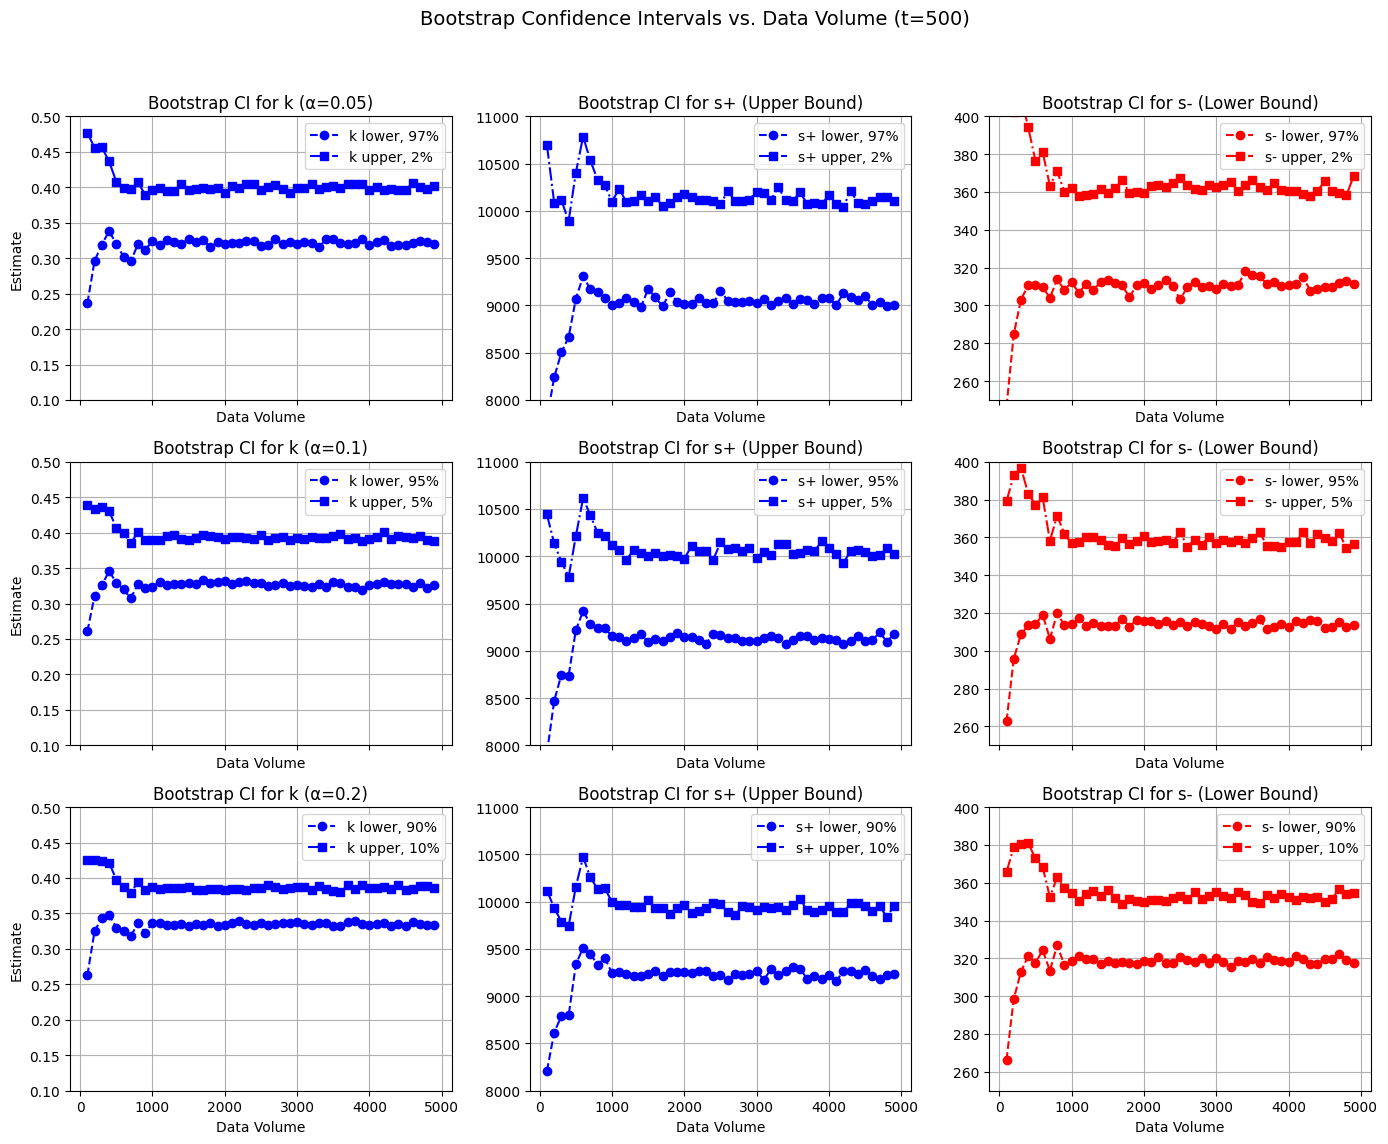

In [4]:
sampling_uncertainty_experiment_v2(B=200)

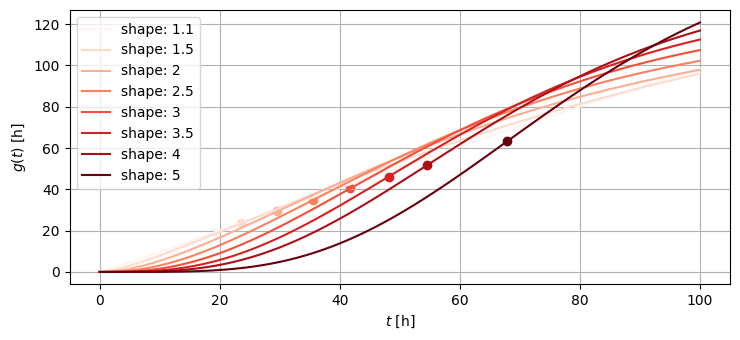

<Figure size 750x350 with 0 Axes>

In [57]:
def gammainc_low(a, z):
    return gammainc(a, 0, z, regularized=True)

def f(x, a: float =3, lambd: float = 0.0478):
    z = float(lambd) * float(x)
    w = gammainc_low(a, z)
    ww = 1 - w
    u = fadd(a, 1)
    u1 = fsub(a, 1)
    v = fdiv(u1, 2)
    y = power(ww, v)
    r = 1 - y
    gn = fmul(a, u)
    gd = float(lambd) * float(fsub(a, 1))
    g1 = fdiv(gn, gd)
    result = g1 * r
    return result

def get_inflection(time, gt):
    dg_dt = np.diff(gt)
    idx_max = np.argmax(dg_dt)
    t_start = time[idx_max]
    return t_start, gt[idx_max]

if __name__ == '__main__':

    a = 3
    lambd = 0.0478
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    T = np.linspace(0, 100, 1000)
    styles = ['-', ':', '-', ':r', '-k', ':k']
    a_vals = [1.1, 1.5, 2, 2.5, 3, 3.5, 4, 5]
    norm = plt.Normalize(min(a_vals), max(a_vals))
    colors = plt.cm.Reds(np.linspace(0, 1, len(a_vals)))
    for a,  col in zip(a_vals, colors):
        Gt = np.array([float(f(t, a=a, lambd=lambd)) for t in T])
        plt.plot(T, Gt,  label=f'shape: {a}', color= col)
        t_max, g_max = get_inflection(T, Gt)
        plt.scatter(t_max, g_max, color=col)
    plt.legend()
    plt.grid()
    plt.xlabel(r'$t$ [h]')
    plt.ylabel(r'$g(t)$ [h]')
    plt.show()


In [58]:
T = np.linspace(0, 100, 1000)  # Example: create a time vector

n_loops = 500
lambd_true = 0.0478
a_true = 4

Gt_save_nsam, tg_max_nsam = [],  []
COLS = ['r', 'b', 'k', 'g']
num_samples_list = [10, 50]

for Id, num_samples in enumerate(num_samples_list):
  COLOR = COLS[Id]
  Gt_save, tg_max, cpu_time = [], [], []

  for step in range(n_loops):
      # gamma random numbers....
      ttf_data = np.random.gamma(shape=a_true, scale=1/lambd_true, size=num_samples)
      # Estimate shape (a), loc, and scale (1/lambd) from ttf_data
      a_estimate, loc, scale_estimate = gamma.fit(ttf_data, floc=0)
      lambd_estimate = 1 / scale_estimate
      #tic = time.time()
      if step in [9, 99, 499]:
        print(f'step: {step+1}/{n_loops}')
        print(f'Estimators: Shape (a) = {a_estimate:.4f}, Lambda = {1 / scale_estimate:.4f}')
      # Get exact g(t)
      Gt = np.array([float(f(t, a=a_estimate, lambd=lambd_estimate)) for t in T])
      Gt_save.append(Gt)
      #toc = tic - time.time()
      # Get inflection point
      t_max, g_max = get_inflection(T, Gt)
      tg_max.append([t_max, g_max])
      #cpu_time.append(toc)
  Gt_save_nsam.append(Gt_save)
  tg_max_nsam.append(tg_max)



step: 10/500
Estimators: Shape (a) = 4.3909, Lambda = 0.0509
step: 100/500
Estimators: Shape (a) = 5.6396, Lambda = 0.0633
step: 10/500
Estimators: Shape (a) = 3.7903, Lambda = 0.0469
step: 100/500
Estimators: Shape (a) = 6.5882, Lambda = 0.0834


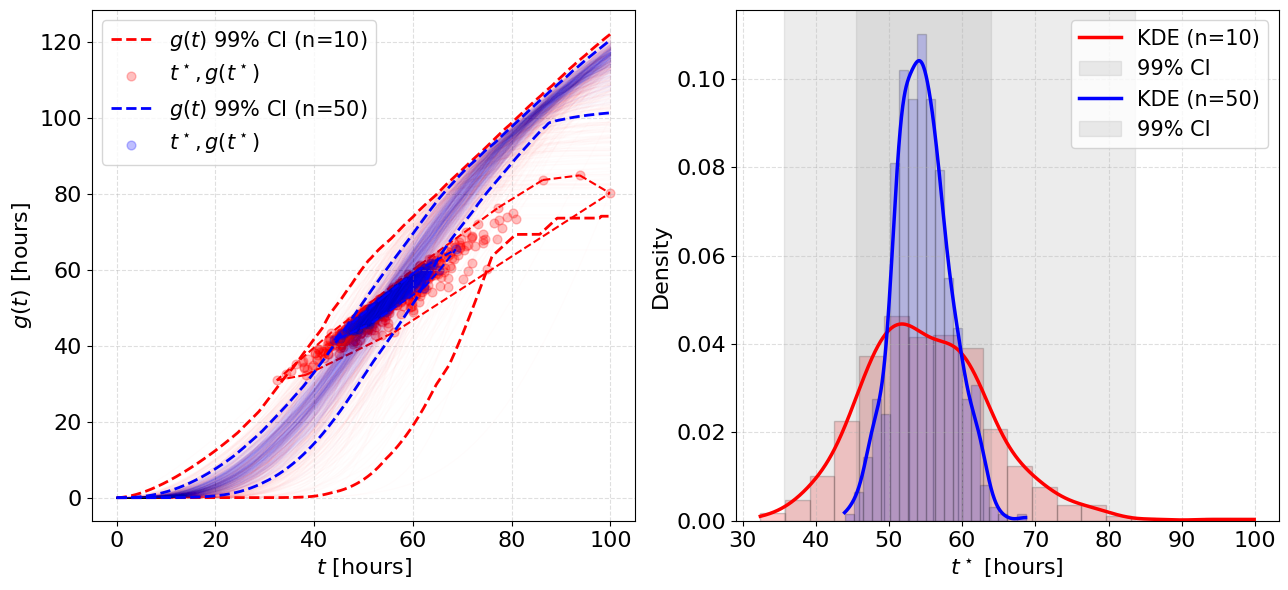

In [64]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 6))

for Gt_save, tg_max, COLOR, num_samples in zip(Gt_save_nsam, tg_max_nsam, COLS, num_samples_list):
    Gt_array = np.array(Gt_save)
    Gt_lower = np.percentile(Gt_array, 0.5, axis=0)
    Gt_upper = np.percentile(Gt_array, 99.5, axis=0)

    # Plot G(t) curves
    for Gt in Gt_array:
        axs[0].plot(T, Gt, COLOR, alpha=0.01, linewidth=1)

    # CI bounds
    axs[0].plot(T, Gt_lower, f'{COLOR}--', linewidth=2, label=f'$g(t)$ 99% CI (n={num_samples})')
    axs[0].plot(T, Gt_upper, f'{COLOR}--', linewidth=2)

    # Scatter extrema
    t_max_values = [t for t, _ in tg_max]
    g_max_values = [g for _, g in tg_max]
    axs[0].scatter(t_max_values, g_max_values, color=COLOR, alpha=0.25, s=40, label=r'$t^\star, g(t^\star)$')

    # Convex hull
    if len(t_max_values) >= 3:
        points = np.column_stack((t_max_values, g_max_values))
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            axs[0].plot(points[simplex, 0], points[simplex, 1], f'{COLOR}--', linewidth=1.5)

    # KDE and histogram of t*
    axs[1].hist(t_max_values, bins=20, density=True, color=COLOR, alpha=0.2, edgecolor='black')
    kde = gaussian_kde(t_max_values)
    x_vals = np.linspace(min(t_max_values), max(t_max_values), 1000)
    axs[1].plot(x_vals, kde(x_vals), color=COLOR, lw=2.5, label=f'KDE (n={num_samples})')

    # 99% CI on t*
    lower_ci = np.percentile(t_max_values, 0.5)
    upper_ci = np.percentile(t_max_values, 99.5)
    axs[1].axvspan(lower_ci, upper_ci, color='gray', alpha=0.15, label='99% CI')

# Axes formatting — bigger fonts
for ax in axs:
    ax.tick_params(labelsize=16)
    ax.grid(True, linestyle='--', alpha=0.4)

axs[0].set_xlabel(r'$t$ [hours]', fontsize=16)
axs[0].set_ylabel(r'$g(t)$ [hours]', fontsize=16)
axs[0].legend(fontsize=15, loc='upper left')

axs[1].set_xlabel(r'$t^\star$ [hours]', fontsize=16)
axs[1].set_ylabel('Density', fontsize=16)
axs[1].legend(fontsize=15, loc='upper right')

plt.tight_layout()
plt.savefig("../plots/Gamma_Inflection_Epistemic_uncertain.svg", format="svg")
plt.show()
